Data Exploration for Test Dataset

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df_1):
    # Downcast numerical columns
    for col in df_1.columns:
        col_type = df_1[col].dtypes
        if col_type == 'int64':
            df_1[col] = df_1[col].astype('int32')
        elif col_type == 'float64':
            df_1[col] = df_1[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df_1[col] = df_1[col].astype('category')
    return df_1

chunks = []
test_dataset = r"C:\Users\THIRU\OneDrive\Desktop\project_4\GUIDE_Test.csv"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(test_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df_1 = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

df_1.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,3390,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,3658,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1715,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,5148,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,5019,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public



Shape of the dataset: (126027, 38)
Column Names in the Dataset:
Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'DayOfWeek', 'Hour'],
      dtype='object')

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 126027 entries, 55 to 4147824
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  126027 non-null  int32  
 1   OrgId               126027 non-null  int32  
 2   In

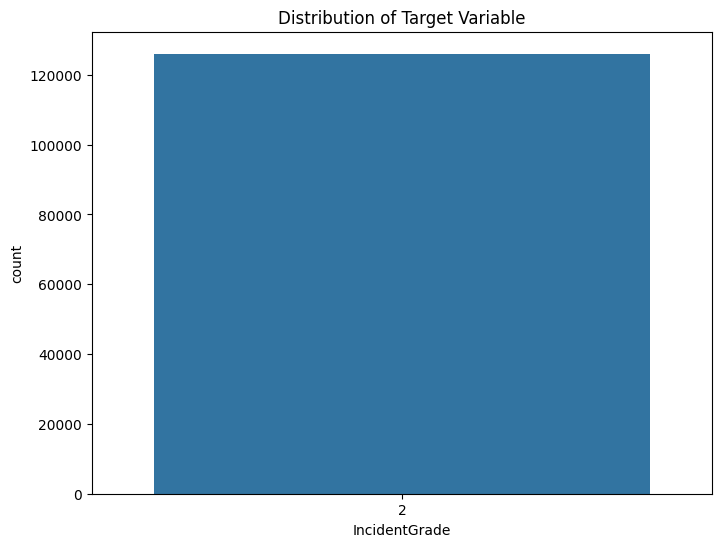

In [29]:
# Shape of the dataset
print("\nShape of the dataset:", df_1.shape)

# Column names
print("Column Names in the Dataset:")
print(df_1.columns)

print("\nDataset Information:")
print(df_1.info())

# Check for missing values
print("\nMissing values:")
print(df_1.isnull().sum())

# Check for duplicate rows
duplicate_count = df_1.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df_1['IncidentGrade'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=df_1['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

Data Cleaning and Preprocessing for Test Dataset

In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

def calculate_missing_percentage(df):
    """Calculate and return percentage of missing values for each column."""
    missing_percentage = df.isnull().sum() / len(df) * 100
    return missing_percentage

def drop_columns_with_missing_values(df, threshold=50):
    """Drop columns with missing values above a specified threshold percentage."""
    missing_percentage = calculate_missing_percentage(df)
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    print(f"Columns with more than {threshold}% missing values are dropped:")
    print(columns_to_drop)
    df.drop(columns=columns_to_drop, axis=1, inplace=True)
    return df

def impute_missing_values(df):
    """Impute missing values for numeric and categorical columns."""
    # Impute numeric columns with median
    numeric_columns = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
    for col in numeric_columns:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Imputed numeric column '{col}' with median value: {median_val}")

    # Impute categorical columns with mode
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

    return df

def remove_outliers(df, iqr_multiplier=1.5):
    """Remove outliers from numeric columns using the IQR method."""
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

def extract_datetime_features(df):
    """Extract datetime features from the 'Timestamp' column."""
    if 'Timestamp' in df.columns:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
        df['Year'] = df['Timestamp'].dt.year
        df['Month'] = df['Timestamp'].dt.month
        df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
        df['Hour'] = df['Timestamp'].dt.hour
        df.drop(columns=['Timestamp'], inplace=True)  # Drop 'Timestamp' column after feature extraction
    else:
        print("No 'Timestamp' column found to extract features.")
    return df

def scale_numeric_features(df, id_columns):
    """Scale numeric features excluding ID columns."""
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64'])
    numeric_features = numeric_features.drop(columns=id_columns, errors='ignore')
    scaler = MinMaxScaler()
    df[numeric_features.columns] = scaler.fit_transform(numeric_features)
    return df

def encode_categorical_columns(df, categorical_columns):
    """Label encode specified categorical columns."""
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        if col in df.columns:
            df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary
    return df

def preprocess_data(df, id_columns, categorical_columns):
    """Main function to preprocess the data."""
    df = drop_columns_with_missing_values(df)  # Drop columns with > 50% missing values
    df = impute_missing_values(df)  # Impute missing values for numeric and categorical columns
    df = remove_outliers(df)  # Remove outliers based on IQR
    df = extract_datetime_features(df)  # Extract datetime features
    df = scale_numeric_features(df, id_columns)  # Scale numeric features
    df = encode_categorical_columns(df, categorical_columns)  # Label encode categorical columns
    df.drop_duplicates(inplace=True)  # Remove duplicate rows
    return df

# Define ID columns and categorical columns
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'City', 
              'CountryCode', 'State']

categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

# Assuming df_1 is your original DataFrame
df_1 = preprocess_data(df_1, id_columns, categorical_columns)

# Save the processed DataFrame
output_path = r"C:\Users\THIRU\OneDrive\Desktop\project_4\test_cleaned_dataset.csv"
df_1.to_csv(output_path, index=False)

print(f"Data preprocessing complete and saved at: {output_path}")


Columns with more than 50% missing values are dropped:
Index([], dtype='object')
No 'Timestamp' column found to extract features.
Data preprocessing complete and saved at: C:\Users\THIRU\OneDrive\Desktop\project_4\test_cleaned_dataset.csv


Logistic Regression

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv(r"C:\Users\THIRU\OneDrive\Desktop\project_4\train_cleaned_dataset.csv")

# Check for categorical columns and encode them
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)  
y = df['IncidentGrade']  

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize StandardScaler for feature scaling
scaler = StandardScaler()

# Fit and transform the training data, and transform the validation data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize logistic regression with grid search for hyperparameter tuning
logreg = LogisticRegression(solver='liblinear')

# Hyperparameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

# Get the best model
best_logreg = grid_search.best_estimator_
# Evaluate the model on validation data
y_pred = best_logreg.predict(X_val_scaled)

# Print results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Best Hyperparameters from GridSearchCV:
{'C': 1, 'penalty': 'l2'}
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      8928
           1       0.84      0.55      0.66      8470
           2       0.94      0.96      0.95     76207

    accuracy                           0.90     93605
   macro avg       0.80      0.74      0.76     93605
weighted avg       0.90      0.90      0.90     93605

Confusion Matrix:
[[ 6306   562  2060]
 [ 1305  4661  2504]
 [ 2556   333 73318]]


Decision Tree

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import randint

# Load the dataset
df = pd.read_csv(r"C:\Users\THIRU\OneDrive\Desktop\project_4\train_cleaned_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Handle missing values for numeric and categorical columns
# Fill NaN in numeric columns with the median
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())

# Fill NaN in categorical columns with the mode
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X[col] = X[col].fillna(X[col].mode()[0])  # For categorical columns, fill NaN with mode

# Encode categorical columns using LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])

# Scale numerical features
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Decision Tree Classifier
dtree = DecisionTreeClassifier(random_state=42)

# Hyperparameter grid for RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'splitter': ['best', 'random']
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(dtree, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters from RandomizedSearchCV:")
print(random_search.best_params_)

# Get the best model from RandomizedSearchCV
best_dtree = random_search.best_estimator_

# Evaluate the model on validation data
y_pred = best_dtree.predict(X_val)

# Print results
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


c:\Users\THIRU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
160 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
131 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\THIRU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\THIRU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\THIRU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base

Best Hyperparameters from RandomizedSearchCV:
{'criterion': 'entropy', 'max_depth': 41, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'splitter': 'best'}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8928
           1       0.96      0.96      0.96      8470
           2       1.00      1.00      1.00     76207

    accuracy                           0.99     93605
   macro avg       0.97      0.98      0.97     93605
weighted avg       0.99      0.99      0.99     93605

Confusion Matrix:
[[ 8689   151    88]
 [  211  8100   159]
 [   94   185 75928]]


Random Forest Classifier

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv(r"C:\Users\THIRU\OneDrive\Desktop\project_4\train_cleaned_dataset.csv")

# Handle missing values
df = df.fillna(df.median(numeric_only=True))  # For numeric columns
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    # Handle timestamp columns
    if pd.api.types.is_datetime64_any_dtype(df[col]) or 'T' in str(df[col].iloc[0]):
        df[col] = pd.to_datetime(df[col], errors='coerce').astype(int) // 10**9  # Convert to UNIX timestamp
    else:
        df[col] = df[col].fillna(df[col].mode()[0])  # Fill with mode for other categorical columns

# Encode categorical variables if any
label_encoder = LabelEncoder()
for col in categorical_columns:
    if df[col].dtype == 'object':
        df[col] = label_encoder.fit_transform(df[col])

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Ensure target variable is encoded if it is categorical
if y.dtype == 'object':
    y = label_encoder.fit_transform(y)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=200,    # Number of trees
    max_features='sqrt', # Select features per split
    max_depth=30,        # Max depth of the tree
    min_samples_split=4, # Minimum samples to split
    min_samples_leaf=2,  # Minimum samples per leaf
    random_state=42
)

# Train the model
rf.fit(X_train, y_train)

# Evaluate the model on validation data
y_pred = rf.predict(X_val)

# Print results
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      8928
           1       0.96      0.95      0.95      8470
           2       1.00      0.99      1.00     76207

    accuracy                           0.99     93605
   macro avg       0.97      0.97      0.97     93605
weighted avg       0.99      0.99      0.99     93605

Confusion Matrix:
[[ 8637   210    81]
 [  244  8035   191]
 [  268   130 75809]]


Gradient Boosting Machines - XGBoost

In [7]:
! pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Load dataset
df = pd.read_csv(r"C:\Users\THIRU\OneDrive\Desktop\project_4\train_cleaned_dataset.csv")

# Handle missing values
df = df.fillna(df.median(numeric_only=True))  # For numeric columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])  # For categorical columns

# Encode categorical variables if present
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Encode target variable if it is categorical
if y.dtype == 'object':
    y = label_encoder.fit_transform(y)

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    subsample=0.8,
    n_estimators=200,
    max_depth=9,
    learning_rate=0.2,
    colsample_bytree=1.0,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Evaluate the model on validation data
y_pred = xgb_clf.predict(X_val)

# Print the evaluation results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8928
           1       0.97      0.97      0.97      8470
           2       1.00      1.00      1.00     76207

    accuracy                           0.99     93605
   macro avg       0.98      0.98      0.98     93605
weighted avg       0.99      0.99      0.99     93605

Confusion Matrix:
[[ 8693   163    72]
 [  138  8196   136]
 [   85   120 76002]]


Best Model selection

In [10]:
import pandas as pd

report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy':[0.91,0.98,0.99,0.99],
    'Macro-F1 Score':[ 0.76, 0.93, 0.98, 0.98],
    'Precision': [0.80,0.92,0.98,0.98],
    'Recall': [0.73,0.94,0.98 ,0.98]

}

# Convert to DataFrame
df = pd.DataFrame(report)

# Print comparison table
print("Comparison Table:")
print(df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = df.loc[df['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression      0.91            0.76       0.80    0.73
      Decision Tree      0.98            0.93       0.92    0.94
      Random Forest      0.99            0.98       0.98    0.98
            XGBoost      0.99            0.98       0.98    0.98

Best Model Based on Macro-F1 Score:
Model             Random Forest
Accuracy                   0.99
Macro-F1 Score             0.98
Precision                  0.98
Recall                     0.98
Name: 2, dtype: object


Feature Importance and Error Analysis

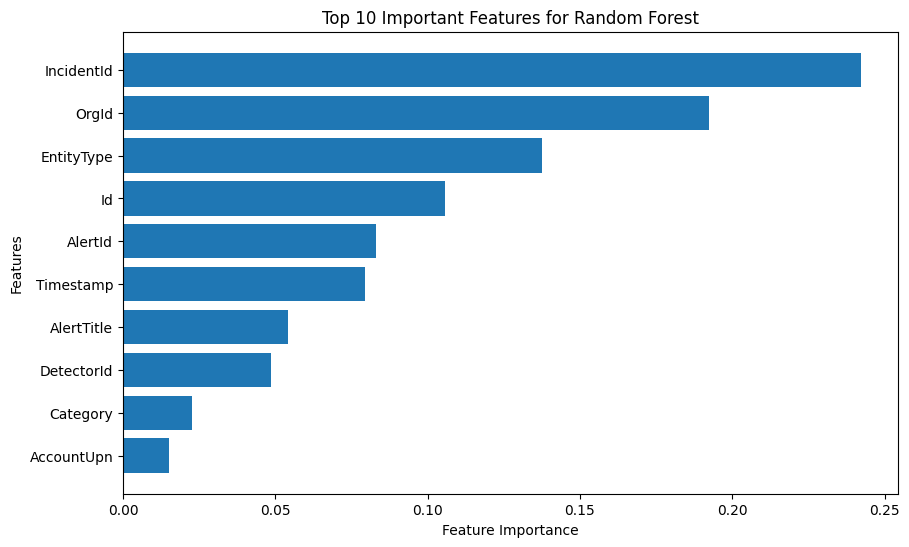

          Id  OrgId  IncidentId  AlertId  Timestamp  DetectorId  AlertTitle  \
45037   2996     55      119779   100739     125811           1    0.002278   
460623  5097    126      124205  1010729     242968           0    0.000000   
73517   3065     55       21171     6189     124441           1    0.002278   
419611  3784    239       98961  1003388      54959           0    0.000000   
208692  4193    330       26456   541532       1672           7    0.013667   

        Category  EntityType  EvidenceRole  ...  ApplicationName  \
45037          5           5             1  ...           3421.0   
460623         5           0             1  ...           3421.0   
73517          5           5             1  ...           3421.0   
419611         5           0             1  ...           3421.0   
208692         5           0             1  ...           3421.0   

        OAuthApplicationId  FileName  FolderPath  ResourceIdName  OSFamily  \
45037                881.0  289573.0  

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Get feature importances from the best Random Forest model
importances = rf.feature_importances_

features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importance for top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

# Identify misclassified samples
misclassified_idx = (y_val != y_pred)

# Extract the misclassified samples
misclassified_samples = X_val[misclassified_idx].copy()

# Display the first 5 misclassified samples
print(misclassified_samples.head(5))

# Evaluate the model's predictions
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Saving the Best Model

In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load dataset
df = pd.read_csv(r"C:\Users\THIRU\OneDrive\Desktop\project_4\train_cleaned_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing for numeric columns (impute missing values and scale)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Scale numerical features
])

# Preprocessing for categorical columns (impute missing values and one-hot encode)
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding for categorical variables
])

# Combine preprocessors into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Train the Random Forest model with optimizations
rf = RandomForestClassifier(
    n_estimators=100,  # Fewer trees
    max_depth=20,      # Shallower depth
    max_features="sqrt",  # Consider a subset of features
    random_state=42
)
rf.fit(X_train_resampled, y_train_resampled)

# Predict on the processed validation data
y_pred = rf.predict(X_val_processed)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.87      0.70      8928
           1       0.76      0.51      0.61      8470
           2       0.96      0.94      0.95     76207

    accuracy                           0.89     93605
   macro avg       0.76      0.77      0.75     93605
weighted avg       0.90      0.89      0.89     93605

Confusion Matrix:
[[ 7768   466   694]
 [ 1812  4292  2366]
 [ 3818   921 71468]]


In [27]:
# Save the entire pipeline (including SMOTE and RandomForest)
model_path = r"C:\Users\THIRU\OneDrive\Desktop\project_4\model.pkl.txt"
dump(pipeline, model_path)  # Saving the entire pipeline, not just the classifier
print(f"Model saved to {model_path}")

Model saved to C:\Users\THIRU\OneDrive\Desktop\project_4\model.pkl.txt


Evaluation of Selected Random Forest Model on Test Data

In [78]:
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix

# Load the saved Random Forest model
model_path = r"C:\Users\THIRU\OneDrive\Desktop\project_4\model.pkl.txt"
best_rf = load(model_path)

# Load the test dataset
test_data_path = r"C:\Users\THIRU\OneDrive\Desktop\project_4\test_cleaned_dataset.csv"
test_df = pd.read_csv(test_data_path)

# Drop unexpected columns like 'Unnamed: 0' if present
if 'Unnamed: 0' in test_df.columns:
    test_df = test_df.drop(columns=['Unnamed: 0'])

# Separate features and target from test data
X_test = test_df.drop('IncidentGrade', axis=1)
y_test = test_df['IncidentGrade']

# Get model's expected features
model_features = best_rf.feature_names_in_

In [77]:
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix

# Load the saved Random Forest model
model_path = r"C:\Users\THIRU\OneDrive\Desktop\project_4\model.pkl.txt"
best_rf = load(model_path)

# Load the test dataset
test_data_path = r"C:\Users\THIRU\OneDrive\Desktop\project_4\test_cleaned_dataset.csv"
test_df = pd.read_csv(test_data_path)

# Drop unexpected columns like 'Unnamed: 0' if present
if 'Unnamed: 0' in test_df.columns:
    test_df = test_df.drop(columns=['Unnamed: 0'])

# Separate features and target from test data
X_test = test_df.drop('IncidentGrade', axis=1)
y_test = test_df['IncidentGrade']

# Get model's expected features
model_features = best_rf.feature_names_in_

# Check for missing features in the test set
missing_features = [feature for feature in model_features if feature not in X_test.columns]
if missing_features:
    print(f"Adding missing features to test set: {missing_features}")
    for feature in missing_features:
        X_test[feature] = 0  # Add missing features with default value (e.g., 0)

# Reorder test features to match model's expected order
X_test = X_test[model_features]

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Extract macro-F1 score, precision, and recall from the report
macro_f1 = report['macro avg']['f1-score']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']

print("\nMacro-F1 Score: {:.2f}".format(macro_f1))
print("Macro Precision: {:.2f}".format(macro_precision))
print("Macro Recall: {:.2f}".format(macro_recall))

# Confusion Matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))

Adding missing features to test set: ['Timestamp']


NotFittedError: Pipeline is not fitted yet.